In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import inspect
import datetime
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
import Lyapunov_funcs as ly

# Generate test data
## Define logistic function

In [3]:
# define function
def logistic_fn(mu,xi):
    return mu*xi * (1-xi)


# compute function
def compute_fn (mu,x0 = 1e-99, length = 500):
    
    function = []

    for i in range(0,length): # generate array with index 0 -> 99
        if i == 0:
            function.append(x0)
        else:
            previous_value = function[i - 1]
            function.append(logistic_fn(mu,previous_value))
            
    return function

In [4]:
mu = np.arange(0, 4, 0.0004)
bifurcation = []

for i in mu:
    population = compute_fn(mu = i)[-1]
    bifurcation.append([i,population])
    
bifurcation = np.array(bifurcation)

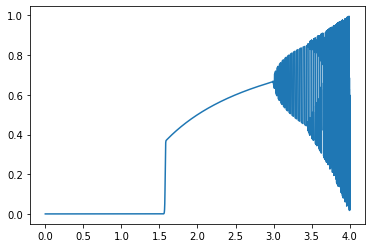

In [5]:
plt.plot(bifurcation[:,0], bifurcation[:,1]);

## Generate test data set from logistic function

Function defined by:
$$ x_{i+1} = \mu x_{i} (1-x_{i}) $$ 

Rosenstein used $\mu$ = 4, $\Delta$t = 1. This gives a value for $\lambda_{1}$ = 0.678 when N = 500, J = 2, m = 2

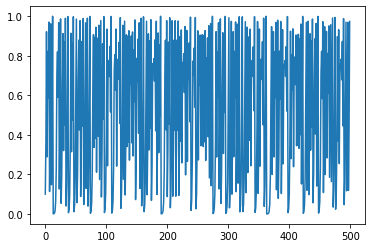

In [6]:
logistic_data = compute_fn(mu = 4, x0 = 0.1, length = 500)

plt.plot(logistic_data);

# Implement Rosenstein's algorithm

## Estimate lag J

J approximated to equal the lag where the autocorrelation function drops to 1 - 1 /e of its initial value.

In [ ]:
plot_acf(pd.Series(logistic_data))

In [ ]:
logistic_data

## Calculate mean period of time series 

$$\mu = 1/T $$

Where T is the mean period of the time series' power spectrum

In [ ]:
plt.plot(periodogram(logistic_data)[0],periodogram(logistic_data)[1])

In [ ]:
def calc_mean_period (timeseries):
    power_spectrum = periodogram(timeseries)[1]
    frequencies = periodogram(timeseries)[0]

    
    weights = power_spectrum / sum(power_spectrum)
    return 1/np.average(frequencies, weights = weights)

## Put data into phase space

Each row represents a different value for i

Each column is a different j value 

Total length of each column is M

Total width of matrix is m (embedding dimension)

Each column seperated by lag J 

First value of each row represents the original time series

In [ ]:
def gen_phase_space_matrix(timeseries, J, m):

    matrix = pd.DataFrame(columns = np.arange(0,m))
    
    for i, val in enumerate(timeseries):
     
        x_i = []

        for it in range(0, m):
            
            try:
                i_plus_j = timeseries[i + J*it]
                x_i.append(i_plus_j)
            except:
                x_i.append(np.nan)
        
        matrix.loc[i] = x_i
    return matrix
    

In [ ]:
test_matrix = gen_phase_space_matrix(logistic_data, J=1, m=2)
test_matrix

## Find initial distance to nearest neighbour

1. For first row (i = 0), search for the nearest neighbour - entry with the smallest Euclidian distance to the row (i.e. pass both rows of matrix as m-dimensional points to euclidian function). This is distance dj(0)

2. Calculate the distance between these points for the following rows to get dj(i). Resulting matrix of distances will be M rows long.

In [ ]:
def euc_distance (p1, p2):
    try: 
        return distance.euclidean (p1,p2)
    except:
        return np.inf


def find_nearest_neighbour (dataframe, ref_index, mean_period, i_max = 25):
    
    dists = []
    ref_row = dataframe.iloc[ref_index, :]
        
    for i in range(0,dataframe.shape[0] - i_max):
        test_row = dataframe.iloc[i, :]
                
#         print("not equal = ",i != ref_index)  
#         print("mean period = ",abs(i-ref_index) > mean_period)  
#         print("combined = ",i != ref_index and abs(i-ref_index) > mean_period)  
#         print("")
            
        if i != ref_index and abs(i-ref_index) > mean_period:
            dist = euc_distance(ref_row, test_row)
        else:
            dist = np.inf
            
        dists.append(dist)
        
    dists = pd.DataFrame(dists,columns = ['euc_distance'])
    dists = dists.sort_values(by = 'euc_distance', ascending = True)                  
    
    return dists.head(1).index.values[0]


In [ ]:
mean_period = calc_mean_period(logistic_data)

In [ ]:
NN_pairs = []

for i in range(0,test_matrix.shape[0]):
    NN = find_nearest_neighbour(test_matrix, ref_index= i, mean_period = mean_period)
    NN_pairs.append([i,NN])

## Calculate divergence of nearest neighbours

In [ ]:
def expected_log_distance(dataframe, NN_pairs, i_max = 25): 
    
    dj_data = []
    
    for i in range (0,i_max): # calculate divergence through i_max steps
        
        dj_i = []
    
        for k in range (0,(dataframe.shape[0] - i_max)): # compute for all nearest neighbour pairs 
            
            NN_1 = NN_pairs[k][0]
            NN_2 = NN_pairs[k][1]
            
            p1 = dataframe.iloc[NN_1 + i, :]
            p2 = dataframe.iloc[NN_2 + i, :]
            
            dj_i.append(euc_distance(p1,p2))
                
        
        dj_data.append([i,np.mean(np.log(dj_i))])
        

    return dj_data

In [ ]:
lyaponov_data = pd.DataFrame(expected_log_distance(test_matrix, NN_pairs), columns = ['i','log(dj)'])

## Get Lyapunov exponent by linear fit

Lyapunov exponent $\lambda _{1}$ can be found from the following equation

$$ ln(d_{j}(i)) = \lambda _{1}i\Delta t + ln(d_{j}(0)) $$

In [ ]:
time_lag = 1

plt.plot(lyaponov_data['i']*time_lag, lyaponov_data['log(dj)'])
plt.xlabel('time_lag')
plt.ylabel('ln(dj_i)')

linearEnd = 9
plt.axvline(linearEnd) # reference line for estimating the end of linear section

plt.show()


In [ ]:
#Hone in on linear section of curve
fit_data = lyaponov_data[0:linearEnd]

x = fit_data['i'].values.reshape(-1,1)
y = fit_data['log(dj)'].values.reshape(-1,1)

In [ ]:
regressor = LinearRegression()  
regressor.fit(x,y)

Lyapunov_trend = regressor.predict(x)




In [ ]:
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w', edgecolor='k')



plt.plot(lyaponov_data['i']*time_lag, lyaponov_data['log(dj)'], label = 'observed data')
plt.xlabel('time_lag')
plt.ylabel('ln(dj_i)')

plt.plot(x,Lyapunov_trend, label = 'lyapunov fit')

plt.legend(loc = 'best')

plt.show()

print("First Lyapunov exponent is: ", regressor.coef_[0][0])

# 20 Feb meeting

### Presentation 1 feedback
- Eigenvectors and eigenvalues (?)
- Meet before final presentation
- Final presentation - more an extension of what we've already done than a rewrite 
- Focus away from complexity and more on the dynamical system 
- Taken's theorum - explain lagging/phase space transform 
- Next presentation - give recap, but keep up momentum
- Dick James to read final report

### Lyapunov
- Use hourly data rather than daily - costs money, cry about how we're students and see if they give it us for free
- "Certain russian website" with hourly or minutely data - look for American company names 
- "hiroki sayama - introduction to modelling and analysis of complex systems" free textbook to "borrow/steal/cite"
- Print off and sign NDA 
- Ask James Ratcliffe about Comp A
- Simon Crampin's material might give a hint 
- Will and Conor's reports are the best 
- Contact Will Bewley 
- Weight data to remove perturbations???
- Last year's group said hourly works better 
- Consider hourly as well as daily??
- Compare lyapunov for 2 days vs lyapunov for 48 hours of data - Do the answers agree?


In [ ]:
plot_acf(x['Open'])

# Test Lyapunov_funcs.py 

In [9]:
test_period = ly.calc_mean_period(logistic_data)

In [10]:
test_M = ly.gen_phase_space_matrix(logistic_data, J=1, m=2)

In [11]:
test_NN = ly.compute_nearest_neighbours(test_M,test_period)

In [13]:
test_div_data = pd.DataFrame(ly.expected_log_distance(test_M, test_NN), columns = ['i','log(dj)'])

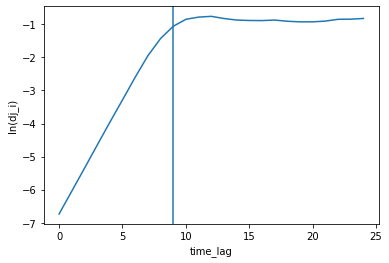

In [14]:
time_lag = 1

plt.plot(test_div_data['i'], test_div_data['log(dj)'])
plt.xlabel('time_lag')
plt.ylabel('ln(dj_i)')

linearEnd = 9
plt.axvline(linearEnd) # reference line for estimating the end of linear section

plt.show()